In [21]:
import sys
sys.path.append("..")
import functools

import numpy as np
import torch
import scipy.linalg
import scipy.optimize
import matplotlib.pyplot as plt
from dict_minimize.torch_api import minimize
import functorch
import pyequion2

import tmcdiff

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl"], from_elements=True, backend="torch", logbase="e",
                                     activity_model="IDEAL")

In [24]:
TK = 298.15
shear_velocity = 0.1
kinematic_viscosity = 1e-6
molal_balance = {'Na':0.075, 'Cl':0.075}

builder = tmcdiff.TransportBuilder(eqsys, TK, shear_velocity,
                           molal_balance, ["Halite"],
                           kreaction="inf",
                           flux_residual_tol=1e-2)
builder.make_grid(3, 3)
builder.set_species()

In [25]:
builder.set_initial_guess_from_bulk()

In [26]:
solsimple = builder.solve_lma(simplified=True);
solfull = builder.solve_lma(simplified=False);
solsimple.success#, solfull.success

True

In [27]:
def flat_residual(x):
    x_ = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.full_residual(c=x_, lma=False)
    return res.flatten()

def flat_objective(x):
    x_ = x.reshape([builder.nspecies, builder.ngrid])
    res = builder.gibbs_free_energy(c=x_)
    return res.flatten()[0]
    
def torch_wrap(f):
    def g(x):
        x = torch.tensor(x, dtype=torch.float)
        res = f(x).detach().numpy()
        return res
    return g

def torch_wrap(f):
    def g(*args):
        args = [torch.tensor(arg, dtype=torch.float) for arg in args]
        res = f(*args).detach().numpy()
        return res
    return g

In [28]:
def make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, nx, nlambd):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = np.concatenate([res1, res2], axis=-1)
        return res
    def jacobian(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        jac11 = d2f(x) - d2g(x, lambd)
        jac12 = -dg(x).T
        jac21 = dg(x)
        jac22 = np.zeros([nlambd, nlambd])
        jac = np.block([[jac11, jac12], [jac21, jac22]])
        return jac
    return residual, jacobian

def make_lagrangian_residual(g, df, dg, nx):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = torch.cat([res1, res2], dim=-1)
        return res
    return residual

def make_lagrangian_residual_torch(g, df, dg, nx, nlambd):
    def residual(xlambd):
        x, lambd = xlambd[..., :nx], xlambd[..., nx:]
        res1 = df(x) - (dg(x).T)@lambd
        res2 = g(x)
        res = torch.cat([res1, res2], axis=-1)
        return res
    return residual

In [35]:
a = torch.tensor([1.0, 2.0], requires_grad = True)
b = torch.tensor([4.0, 0.0, 0.0])
b[[1, 2]] = a
l = b.prod()
l.backward()
a.grad

tensor([8., 4.])

In [29]:
f_t = flat_objective
df_t = functorch.jacrev(f_t)
d2f_t = functorch.hessian(f_t)
g_t = flat_residual
dg_t = functorch.jacrev(g_t)
d2g_t = functorch.jacrev(lambda x, v : (dg_t(x).T)@v)
f = torch_wrap(f_t)
df = torch_wrap(df_t)
d2f = torch_wrap(d2f_t)
g = torch_wrap(g_t)
dg = torch_wrap(dg_t)
d2g = torch_wrap(d2g_t)

equality_constraint = scipy.optimize.NonlinearConstraint(
    g, lb=0.0, ub=0.0, jac = dg, hess=d2g)
bounds = scipy.optimize.Bounds(lb=1e-30, ub=np.inf, keep_feasible=True)
x0 = builder.x.detach().numpy()
x0 = np.exp(x0)
# lambd0 = builder.lambd.detach().numpy()
# xlambd0 = np.concatenate([x0, lambd0], axis=0)

In [30]:
sol = scipy.optimize.minimize(f, x0, jac=df, method='trust-constr',
                              hess=d2f,
                              constraints=equality_constraint,
                              bounds=bounds,
                              options={'verbose':2}) #TNC

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   1   |   0   | -4.1028e+02 | 1.00e+00 | 4.69e-02 | 2.50e-04 |
|   2   |   2   |   1   | -4.1028e+02 | 2.00e+00 | 4.75e-02 | 6.54e-02 |
|   3   |   3   |   3   | -4.1028e+02 | 1.00e+00 | 4.75e-02 | 6.54e-02 |
|   4   |   4   |   4   | -4.1028e+02 | 7.00e+00 | 7.08e-02 | 1.05e-02 |
|   5   |   6   |   6   | -4.1028e+02 | 7.00e-01 | 7.08e-02 | 1.05e-02 |
|   6   |   7   |   7   | -4.1028e+02 | 1.40e+00 | 9.66e-02 | 3.11e-02 |
|   7   |   8   |   8   | -4.1028e+02 | 2.80e+00 | 1.19e-01 | 6.75e-02 |
|   8   |   8   |   8   | -4.1028e+02 | 1.40e+01 | 3.07e-02 | 6.75e-02 |
|   9   |   9   |   9   | -4.1028e+02 | 1.40e+00 | 3.07e-02 | 6.75e-02 |
|  10   |  10   |  10   | -4.1028e+02 | 4.06e-01 | 3.07e-02 | 6.75e-02 |
|  11   |  11   |  11   | -4.1028e+02 | 8.12e-01 | 2.88e-02 | 1.69e-02 |
|  12   |  11   |  11   | -4.1028e+02 | 4.06e+00 | 

In [12]:
b = df(x0)
A = dg(x0).T
lambd0, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
xlambd0 = np.concatenate([x0, lambd0], axis=0)
xlambd0_t = torch.tensor(xlambd0, dtype=torch.float)

In [13]:
h, dh = make_lagrangian_residual_jacobian(g, df, dg, d2f, d2g, len(builder.x), len(builder.lambd))
h_t = make_lagrangian_residual_torch(g_t, df_t, dg_t, len(builder.x), len(builder.lambd))
loss_t = lambda x : torch.sum((h_t(x))**2)
dloss_t = functorch.grad(loss_t)
d2loss_t = functorch.hessian(loss_t)
loss = torch_wrap(loss_t)
dloss = torch_wrap(dloss_t)
d2loss = torch_wrap(d2loss_t)

In [14]:
# sol = scipy.optimize.minimize(loss, xlambd0, jac=dloss, method='TNC',
#                               hess=d2loss) #TNC
# print(sol.success)
# print(sol.fun)

In [20]:
# xlambd0 = sol.x
sol = scipy.optimize.minimize(loss, xlambd0, jac=dloss, method='TNC',
                              hess=d2loss,
                              options={'verbose':2}) #TNC
print(sol.success)
print(sol.fun)

/tmp/ipykernel_3444/933009971.py:2: OptimizeWarning: Unknown solver options: verbose
  sol = scipy.optimize.minimize(loss, xlambd0, jac=dloss, method='TNC',


False
6765.12


In [317]:
# xlambd0_t.requires_grad = True
# optimizer = torch.optim.SGD([xlambd0_t], lr=1e-6, momentum=0.9)
# for i in range(1000):
#     loss = torch.max(h_t(xlambd0_t)**2)
#     loss.backward()
#     optimizer.step()
#     print(loss)

In [318]:
# sol = scipy.optimize.root(h, xlambd0, jac=dh, method="broyden1")
# print(sol.success)
# print(np.max(np.abs(sol.fun)))

In [319]:
x = sol.x[:len(builder.x)]
# x = builder.x.numpy()

In [320]:
logcmu = x.reshape(builder.nspecies, builder.ngrid)
logc = logcmu[:builder.nspecies, :]
c = np.exp(logc)
logc_t = torch.tensor(logc, dtype=torch.float)

Text(0.5, 0, '$y^+$')

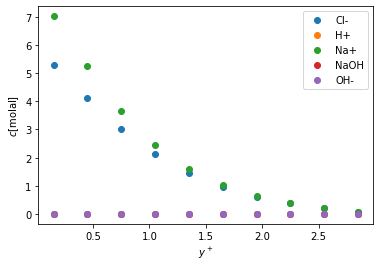

In [321]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

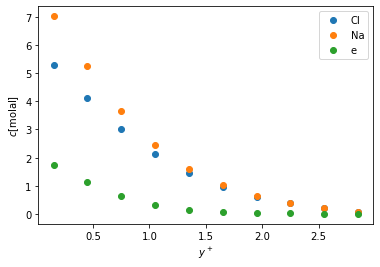

In [322]:
cel = builder.reduced_formula_matrix.numpy()@c
plt.figure()
for i, el in enumerate(eqsys.solute_elements + ['e']):
    plt.plot(builder.ygrid, cel[i, :], 'o', label=el)
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

In [323]:
# fluxes = builder.fluxes().detach().numpy()
# yplot = builder.ypoints[1:-1].detach().numpy()
# plt.figure()
# for i, el in enumerate(eqsys.solute_elements + ['e']):
#     plt.plot(yplot, fluxes[i, :], 'o', label=el)
# plt.legend()
# plt.ylabel(r'$c$[molal]')
# plt.xlabel(r'$y^+$')